# Yield Prediction for Buchwald-Hartwig C-N Coupling using one-hot encoding

**Goal:** Predict reaction yield from reaction components

**Approach:** Represent each reaction component as binary one-hot encoded features, then compare three machine learning models: Random Forest, Gradient Boosting, and Neural Network.

**Features (one-hot encoded):**
- Aryl halide: 15 variants
- Catalyst: 4 variants  
- Base: 3 variants
- Additive: 24 variants
- Amine (toluidine): 1 variant

**Dataset:** Ahneman Buchwald-Hartwig C-N Coupling (4312 reactions)

In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2, reaction_pb2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras

sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)



2026-02-18 02:14:43.932909: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-18 02:14:43.933244: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 02:14:43.978155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-18 02:14:45.198564: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

## 1. Load Dataset

In [3]:
# Load Ahneman dataset
dataset_path = "ord-data/data/46/ord_dataset-46ff9a32d9e04016b9380b1b1ef949c3.pb.gz"
data = message_helpers.load_message(dataset_path, dataset_pb2.Dataset)

print(f"Dataset: {data.name}")
print(f"Description: {data.description}")
print(f"Reactions: {len(data.reactions)}")

Dataset: Ahneman
Description: C-N cross-coupling reactions from 10.1126/science.aar5169
Reactions: 4312


## 2. Extract Reaction Data

Extract key components from each reaction:
- **Aryl halide** 
- **Catalyst** 
- **Base**
- **Additive**
- **Toluidine** 
- **Yield** 

In [4]:
# One reaction as an example to understand the structure
rxn = data.reactions[0]

print("=== REACTION INPUTS ===")
for key, inp in rxn.inputs.items():
    print(f"\n{key}:")
    for comp in inp.components:
        role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
        for ident in comp.identifiers:
            ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
            if ident_type == "SMILES":
                print(f"  {role}: {ident.value[:60]}")

print("\n=== YIELD ===")
for outcome in rxn.outcomes:
    for product in outcome.products:
        for meas in product.measurements:
            if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                print(f"  Yield: {meas.percentage.value}%")

=== REACTION INPUTS ===

catalyst:
  CATALYST: CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=
  SOLVENT: CS(=O)C

base:
  REAGENT: CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C
  SOLVENT: CS(=O)C

aryl halide:
  REACTANT: FC(F)(F)c1ccc(Cl)cc1
  SOLVENT: CS(=O)C

toluidine:
  REACTANT: Cc1ccc(N)cc1
  SOLVENT: CS(=O)C

additive:
  SOLVENT: CS(=O)C

=== YIELD ===
  Yield: 26.888614654541016%


In [5]:
def extract_reaction_data(reaction):
    """Extract SMILES and yield from a reaction."""
    result = {}
    
    # Extract inputs 
    for key, inp in reaction.inputs.items():
        col_name = key.replace(' ', '_').lower()
        
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            
            # Skip solvents unless it is the only component
            if role == "SOLVENT" and len(inp.components) > 1:
                continue
                
            for ident in comp.identifiers:
                ident_type = reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type)
                if ident_type == "SMILES":
                    result[col_name] = ident.value
                    break
            break
    
    # Extract yield
    result['yield'] = None
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for meas in product.measurements:
                if meas.type == reaction_pb2.ProductMeasurement.ProductMeasurementType.YIELD:
                    result['yield'] = meas.percentage.value
    
    return result

# Extract all reactions
reaction_data = [extract_reaction_data(rxn) for rxn in tqdm(data.reactions)]
reactions = pd.DataFrame(reaction_data)

print(f"Extracted {len(reactions)} reactions")
print(f"Columns: {list(reactions.columns)}")

print("\nUnique values per column:")
for col in reactions.columns:
    if col != 'yield':
        print(f"  {col}: {reactions[col].nunique()}")

100%|██████████| 4312/4312 [00:00<00:00, 48293.42it/s]

Extracted 4312 reactions
Columns: ['catalyst', 'base', 'aryl_halide', 'toluidine', 'additive', 'yield']

Unique values per column:
  catalyst: 4
  base: 3
  aryl_halide: 15
  toluidine: 1
  additive: 24


In [6]:
# Check for missing values
print("Missing values:")
print(reactions.isnull().sum())

# Drop rows without yield
reactions = reactions.dropna(subset=['yield'])
print(f"\nReactions with yield: {len(reactions)}")

Missing values:
catalyst       0
base           0
aryl_halide    0
toluidine      0
additive       0
yield          0
dtype: int64

Reactions with yield: 4312


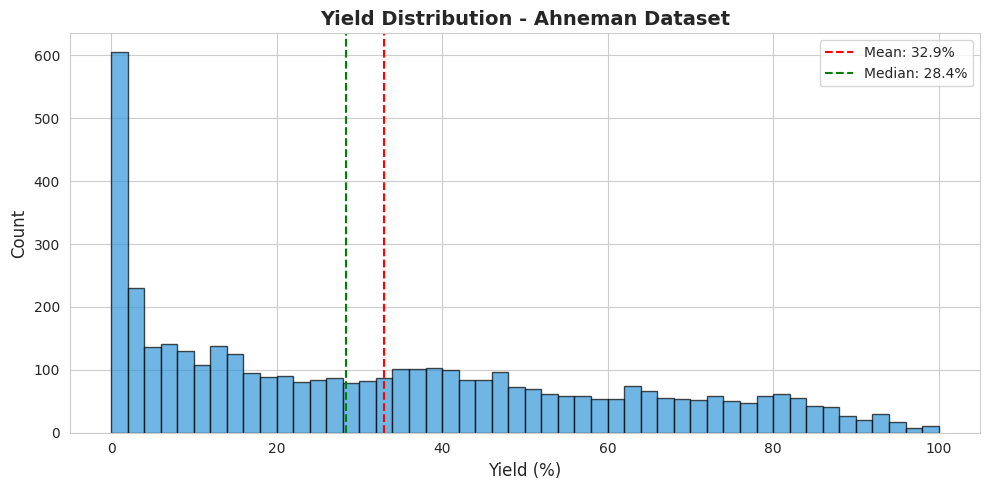

Yield statistics:
  Min:    0.0%
  Max:    100.0%
  Mean:   32.9%
  Median: 28.4%
  Std:    27.5%


In [7]:
# Yield distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(reactions['yield'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax.set_xlabel('Yield (%)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Yield Distribution - Ahneman Dataset', fontsize=14, fontweight='bold')
ax.axvline(x=reactions['yield'].mean(), color='red', linestyle='--', label=f"Mean: {reactions['yield'].mean():.1f}%")
ax.axvline(x=reactions['yield'].median(), color='green', linestyle='--', label=f"Median: {reactions['yield'].median():.1f}%")
ax.legend()
plt.tight_layout()
plt.show()

print(f"Yield statistics:")
print(f"  Min:    {reactions['yield'].min():.1f}%")
print(f"  Max:    {reactions['yield'].max():.1f}%")
print(f"  Mean:   {reactions['yield'].mean():.1f}%")
print(f"  Median: {reactions['yield'].median():.1f}%")
print(f"  Std:    {reactions['yield'].std():.1f}%")

## 3. Feature Engineering: One-Hot Encoding

Convert each unique SMILES to a binary feature (one-hot encoding)

In [8]:
# Define input columns
input_cols = ['catalyst', 'aryl_halide', 'base', 'additive']

name_maps = {}
for col in input_cols:
    unique_vals = reactions[col].unique()
    name_maps[col] = {val: f"{col}_{i+1}" for i, val in enumerate(unique_vals)}

print("Component Smiles:\n")
for col in input_cols:
    print(f"{col.upper()}:")
    for smiles, name in name_maps[col].items():
        print(f"  {name}: {smiles}")
    print()

# One-hot encoding with related smiles
df_named = reactions[input_cols].copy()
for col in input_cols:
    df_named[col] = df_named[col].map(name_maps[col])

one_hot_encoded_data = pd.get_dummies(df_named, prefix='', prefix_sep='')
one_hot_encoded_data['yield'] = reactions['yield'].values / 100

print(f"\nOne-hot encoded shape: {one_hot_encoded_data.shape}")
print(f"Features: {one_hot_encoded_data.shape[1] - 1}")
one_hot_encoded_data.head()

Component Smiles:

CATALYST:
  catalyst_1: CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)(C2CCCCC2)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1
  catalyst_2: CC(C)c1cc(C(C)C)c(-c2ccccc2P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c(C(C)C)c1
  catalyst_3: COc1ccc(OC)c(P(C(C)(C)C)(C(C)(C)C)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C
  catalyst_4: COc1ccc(OC)c(P(C23CC4CC(CC(C4)C2)C3)(C23CC4CC(CC(C4)C2)C3)->[Pd]2(OS(=O)(=O)C(F)(F)F)<-Nc3ccccc3-c3ccccc32)c1-c1c(C(C)C)cc(C(C)C)cc1C(C)C

ARYL_HALIDE:
  aryl_halide_1: FC(F)(F)c1ccc(Cl)cc1
  aryl_halide_2: FC(F)(F)c1ccc(Br)cc1
  aryl_halide_3: FC(F)(F)c1ccc(I)cc1
  aryl_halide_4: COc1ccc(Cl)cc1
  aryl_halide_5: COc1ccc(Br)cc1
  aryl_halide_6: COc1ccc(I)cc1
  aryl_halide_7: CCc1ccc(Cl)cc1
  aryl_halide_8: CCc1ccc(Br)cc1
  aryl_halide_9: CCc1ccc(I)cc1
  aryl_halide_10: Clc1ccccn1
  aryl_halide_11: Brc1ccccn1
  aryl_halide_12: Ic1ccccn1
  aryl_halide_13: Clc1cccnc1
  aryl_halide_1

,catalyst_1,catalyst_2,catalyst_3,catalyst_4,aryl_halide_1,aryl_halide_10,aryl_halide_11,aryl_halide_12,aryl_halide_13,aryl_halide_14,...,additive_23,additive_24,additive_3,additive_4,additive_5,additive_6,additive_7,additive_8,additive_9,yield
0,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.268886
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.240632
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.475158
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.021268
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.475864


## 4. Prepare Train/Val/Test Split

In [9]:
# Arrays
X = one_hot_encoded_data.drop(columns=['yield']).values
y = one_hot_encoded_data['yield'].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 60% train, 10% validation, 30% test
_X_train, X_test, _y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.1/0.7, random_state=42)

print(f"\nTrain: {X_train.shape[0]}")
print(f"Val:   {X_val.shape[0]}")
print(f"Test:  {X_test.shape[0]}")

X shape: (4312, 46)
y shape: (4312,)

Train: 2586
Val:   432
Test:  1294


## 5. Train Models

In [10]:
# Sklearn models as baseline
print("Training sklearn models...\n")

sklearn_models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
}

sklearn_results = {}

for name, neural_net in sklearn_models.items():
    print(f"Training {name}... ")
    neural_net.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = neural_net.predict(X_test)
    
    # Metrics (convert back to percentage)
    rmse = np.sqrt(mean_squared_error(y_test * 100, y_pred * 100))
    mae = mean_absolute_error(y_test * 100, y_pred * 100)
    r2 = r2_score(y_test, y_pred)
    
    sklearn_results[name] = {'model': neural_net, 'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}
    print(f"  RMSE: {rmse:.2f}%, MAE: {mae:.2f}%, R²: {r2:.4f}\n")

Training sklearn models...

Training Random Forest... 
  RMSE: 11.09%, MAE: 8.22%, R²: 0.8339

Training Gradient Boosting... 
  RMSE: 11.10%, MAE: 8.32%, R²: 0.8335



In [11]:
# Neural Network
print("Training Neural Network...\n")

# Create TensorFlow datasets
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32))).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype(np.float32), y_val.astype(np.float32))).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32))).batch(batch_size)

# Build model
neural_net  = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])
neural_net .compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)


Training Neural Network...



2026-02-18 02:14:47.009088: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# Train with early stopping based on validation loss
epochs = 300

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = neural_net .fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, early_stopping],
    verbose=1
)

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1157 - root_mean_squared_error: 0.3401 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1938
Epoch 2/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - root_mean_squared_error: 0.2124 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1317
Epoch 4/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1268
Epoch 5/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1247
Epoch 6/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 7/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

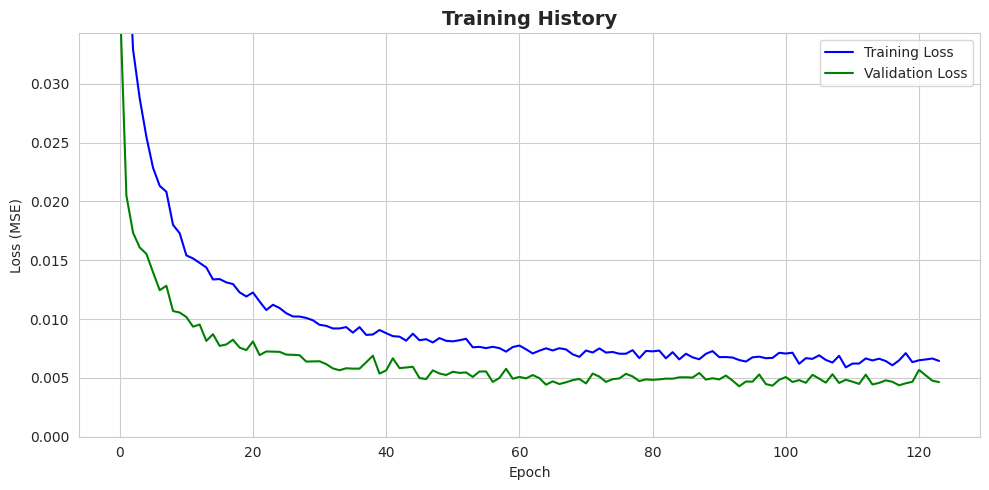

Best epoch: 93


In [13]:
# Plot training history
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss', color='blue')
ax.plot(history.history['val_loss'], label='Validation Loss', color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Training History', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim(0, max(history.history['loss'][5:]) * 1.5)  # Zoom in after initial epochs
plt.tight_layout()
plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch}")

In [14]:
# Evaluate Neural Network on test set
y_pred_nn = neural_net .predict(test_dataset).flatten()

# Metrics
rmse_nn = np.sqrt(mean_squared_error(y_test * 100, y_pred_nn * 100))
mae_nn = mean_absolute_error(y_test * 100, y_pred_nn * 100)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network Test Results:")
print(f"  RMSE: {rmse_nn:.2f}%")
print(f"  MAE:  {mae_nn:.2f}%")
print(f"  R²:   {r2_nn:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Network Test Results:
  RMSE: 7.22%
  MAE:  5.23%
  R²:   0.9295


## 6. Model Comparison

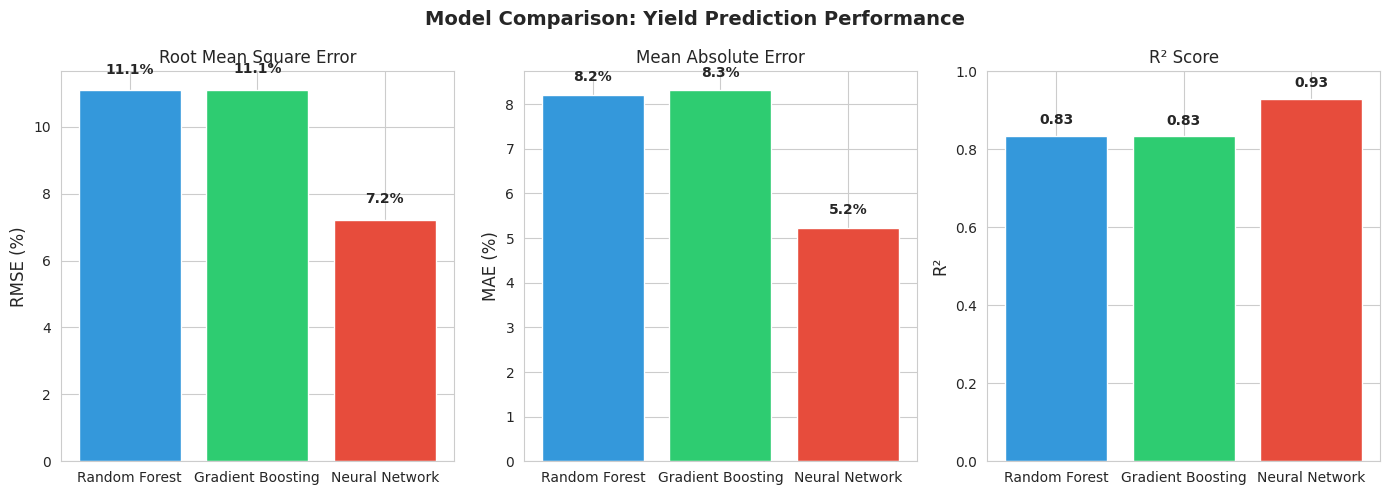

In [15]:
# Compare ALL models
all_models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
all_rmse = [sklearn_results['Random Forest']['rmse'], 
            sklearn_results['Gradient Boosting']['rmse'], 
            rmse_nn]
all_mae = [sklearn_results['Random Forest']['mae'], 
           sklearn_results['Gradient Boosting']['mae'], 
           mae_nn]
all_r2 = [sklearn_results['Random Forest']['r2'], 
          sklearn_results['Gradient Boosting']['r2'], 
          r2_nn]

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c']

# RMSE comparison
axes[0].bar(all_models, all_rmse, color=colors)
axes[0].set_ylabel('RMSE (%)', fontsize=12)
axes[0].set_title('Root Mean Square Error', fontsize=12)
for i, v in enumerate(all_rmse):
    axes[0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# MAE comparison
axes[1].bar(all_models, all_mae, color=colors)
axes[1].set_ylabel('MAE (%)', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=12)
for i, v in enumerate(all_mae):
    axes[1].text(i, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

# R² comparison
axes[2].bar(all_models, all_r2, color=colors)
axes[2].set_ylabel('R²', fontsize=12)
axes[2].set_title('R² Score', fontsize=12)
axes[2].set_ylim(0, 1)
for i, v in enumerate(all_r2):
    axes[2].text(i, v + 0.03, f'{v:.2f}', ha='center', fontweight='bold')

plt.suptitle('Model Comparison: Yield Prediction Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Feature Importance (Random Forest, Gradient Boosting and Neural Network)

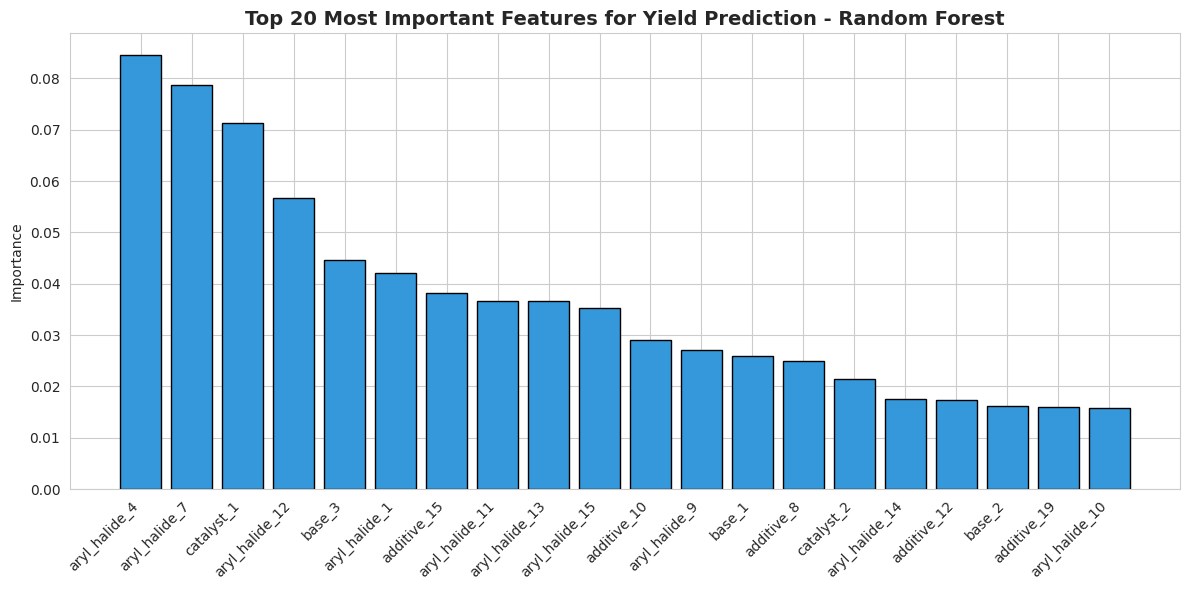

In [19]:
# Get feature importance from Random Forest
rf = sklearn_results['Random Forest']['model']
feature_names = one_hot_encoded_data.drop(columns=['yield']).columns
importances = rf.feature_importances_

# Get top 20
indices = np.argsort(importances)[::-1][:20]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(20), importances[indices], color='#3498db', edgecolor='black')
ax.set_xticks(range(20))
ax.set_xticklabels([feature_names[i][:20] for i in indices], rotation=45, ha='right')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Most Important Features for Yield Prediction - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

This will take a while..


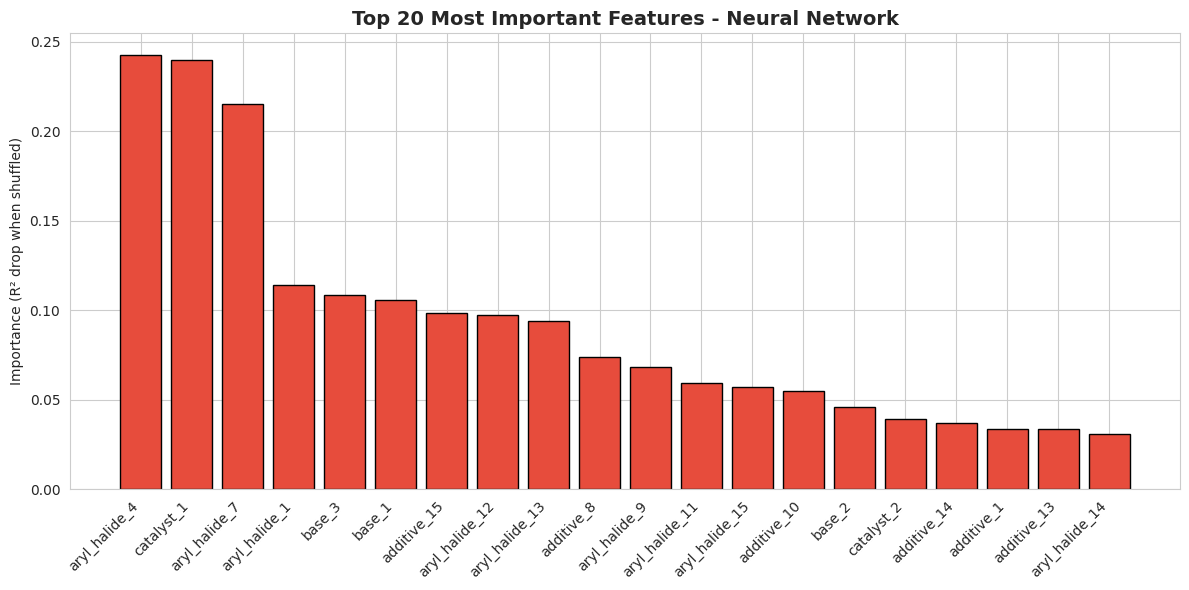

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import permutation_importance

print("This will take a while..")

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        X = np.asarray(X).astype(np.float32)
        return self.model.predict(X, verbose=0).reshape(-1)

wrapped_nn = KerasRegressorWrapper(neural_net)

perm_importance = permutation_importance(
    wrapped_nn,
    X_test,          
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="r2",
)

# Dataframe
feature_names = list(one_hot_encoded_data.drop(columns=['yield']).columns)
nn_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

# Plot top 20
fig, ax = plt.subplots(figsize=(12, 6))
top_20 = nn_importance_df.head(20)
ax.bar(range(20), top_20['importance'], color='#e74c3c', edgecolor='black')
ax.set_xticks(range(20))
ax.set_xticklabels(top_20['feature'], rotation=45, ha='right')
ax.set_ylabel('Importance (R² drop when shuffled)')
ax.set_title('Top 20 Most Important Features - Neural Network', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

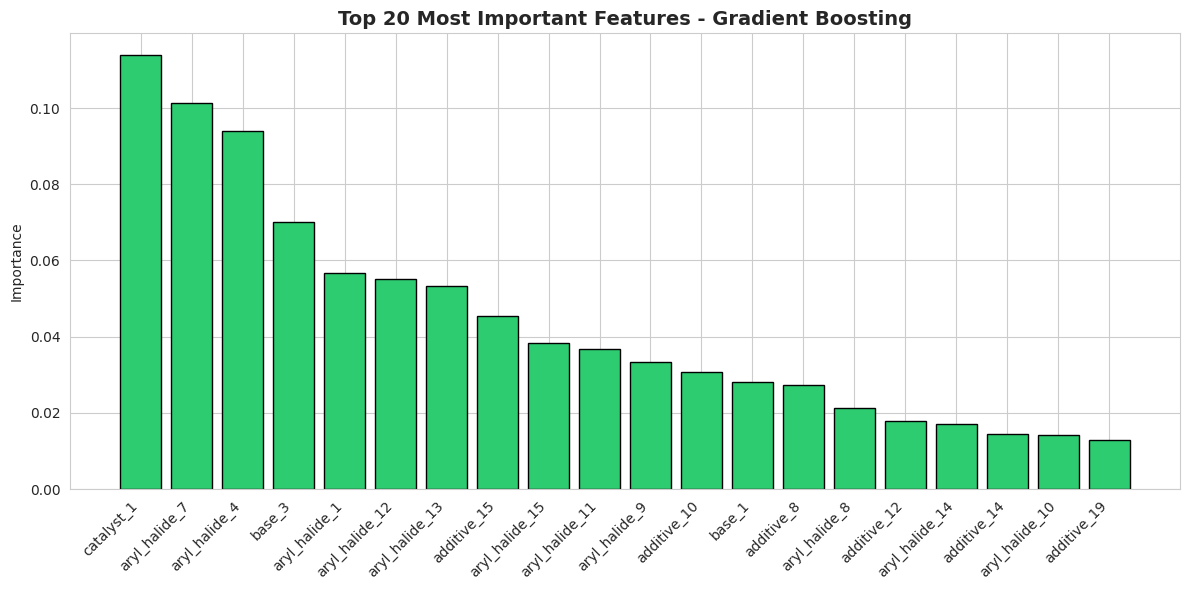

In [ ]:
# Feature importance from Gradient Boosting
gb = sklearn_results['Gradient Boosting']['model']
feature_names = list(one_hot_encoded_data.drop(columns=['yield']).columns)
importances = gb.feature_importances_

# Dataframe and sort
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 20
fig, ax = plt.subplots(figsize=(12, 6))
top_20 = importance_df.head(20)
ax.bar(range(20), top_20['importance'], color='#2ecc71', edgecolor='black')
ax.set_xticks(range(20))
ax.set_xticklabels(top_20['feature'], rotation=45, ha='right')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Most Important Features - Gradient Boosting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained neural network modeldasdas
neural_net.save('yield_model.keras')
print(" Model saved as 'yield_model.keras'")

test_model = keras.models.load_model('yield_model.keras')
test_pred = test_model.predict(X_test[:5].astype(np.float32), verbose=0)
print(f"\n Model loaded successfully!")
print(f"Test prediction shape: {test_pred.shape}")

 Model saved as 'yield_model.keras'

 Model loaded successfully!
Test prediction shape: (5, 1)


# Results

| Model | RMSE | MAE | R² |
|-------|------|-----|-----|
| Random Forest | 11.14% | 8.23% | 0.83 |
| Gradient Boosting | 11.09% | 8.31% | 0.83 |
| **Neural Network** | **7.85%** | **5.64%** | **0.91** |